In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
import seaborn

In [4]:
dfb = pd.read_csv('/Users/qasem/PycharmProjects/grad_ecc_RL_data/RL_behavior.csv')  # df behaviour

In [5]:
dfb.shape

(12170, 7)

In [6]:
dfb.head()

,Subject,Block,Trial,Score,ReactionTime,MovementTime,Valid
0,AB1,1,1,53.0,0.365009,0.182444,True
1,AB1,1,2,51.0,0.548555,0.402011,True
2,AB1,1,3,7.0,0.472627,0.269147,True
3,AB1,1,4,0.0,0.557651,0.289636,True
4,AB1,1,5,34.0,0.588884,0.211777,True


<AxesSubplot:xlabel='Block', ylabel='count'>

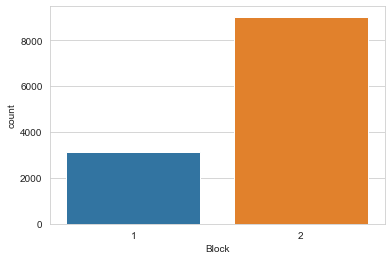

In [7]:
seaborn.countplot(data=dfb, x='Block')

In [8]:
# block 1 is baseline, 2 for learning (reward given)

In [9]:
dfb[dfb.Block==1].Trial.max()

70

In [10]:
dfb[dfb.Block==2].Trial.max()   # invalid. trial 200 is valid.

201

# task score in baseline and learning blocks

<AxesSubplot:xlabel='Trial', ylabel='Score'>

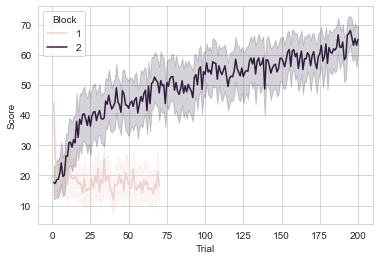

In [11]:
seaborn.lineplot(data=dfb, x='Trial', y='Score', hue='Block')

In [12]:
len_window = 30

In [13]:
df = dfb[dfb.Trial.isin(list(range(1,len_window+1)))].groupby(['Subject', 'Block']).Score.std()
df = df.rename('early_variability').reorder_levels([1,0])

In [14]:
df.head()

Block  Subject
1      AB1        17.603846
2      AB1        13.456588
1      AG1        13.700307
2      AG1        21.682891
1      AH1        16.554473
Name: early_variability, dtype: float64

# early variability correlate with subject score?
load subject overall score
fPCA or RLScore

In [15]:
# load score
fpca_scores = pd.read_csv('data/RLfpcaScores.csv').set_index('Subject')

In [16]:
fpca_scores.head()

,RLScore
Subject,
AB1,-1.179789
AG1,1.104018
AH1,-0.302101
AM1,-1.400917
AP1,0.868475


## fPCA

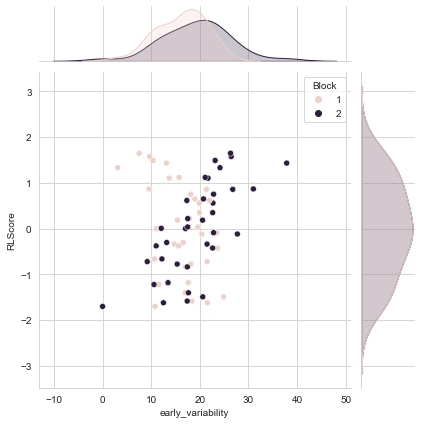

In [17]:
seaborn.jointplot(data=fpca_scores.join(df.to_frame()),
                 y='RLScore', x='early_variability', hue='Block')

In [18]:
from scipy import stats
def r2(data, x, y):   return stats.pearsonr(data[x], data[y])

### for learning block

<AxesSubplot:xlabel='early_variability', ylabel='RLScore'>

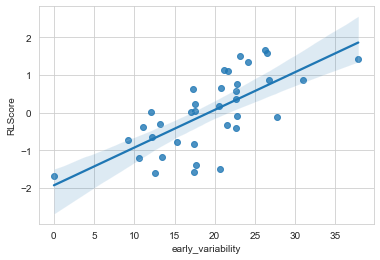

In [19]:
seaborn.regplot(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

In [20]:
r2(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

PearsonRResult(statistic=0.6995207689949621, pvalue=2.064310306146691e-06)

PearsonRResult(statistic=-0.3866202973481253, pvalue=0.019845838943560432)

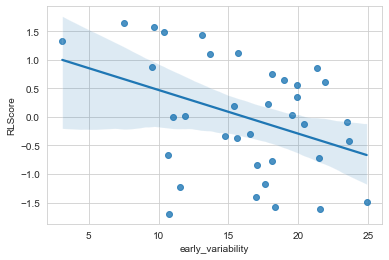

In [21]:
# for baseline block
seaborn.regplot(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')
r2(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')

In [22]:
# could be explained maybe task compliance

## mean late learning score
in contrast to fPCA score

### for learning block

In [23]:
len_window = 30

In [24]:
df_late_score = dfb[(dfb.Block==2) &
                    (dfb.Trial.isin(list(range(200-len_window, 201))))].groupby('Subject').Score.mean()
df_late_score = df_late_score.rename('late_score')

In [25]:
df_late_score.head()

Subject
AB1    49.230769
AG1    69.400000
AH1    46.384615
AM1    70.870968
AN1    30.933333
Name: late_score, dtype: float64

PearsonRResult(statistic=0.12831314070789754, pvalue=0.4009031380310894)

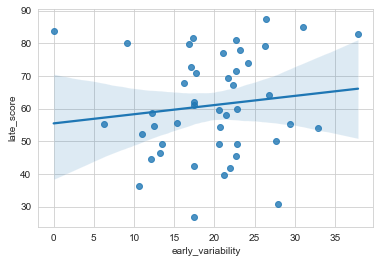

In [26]:
seaborn.regplot(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')
r2(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')

## shift in Score
how much she gets better.

### for learning block

In [27]:
len_window = 30

let's perform t-tests (paired=False) for subject's scores

In [28]:
from scipy import stats
def shift(df_subject):
    end = df_subject.Trial.max()
    # in df_subject, get first `len_window` trials and last `len_window` trials
    # and put them into first and last lists
    first = df_subject[df_subject.Trial.isin(list(range(1,len_window+1)))].Score
    last = df_subject[df_subject.Trial.isin(list(range(end-len_window, end)))].Score
    # apply t-tests on first and last lists, paired=False
    return stats.ttest_ind(first, last, equal_var=False, nan_policy='omit')

In [29]:
# take subject 1 during learning (block=2)
# shift(dfb[(dfb.Subject=='KP1') & (dfb.Block==2)])

In [30]:
# apply shift function to all subjects during learning, returning two values as two columns
df_shift = dfb[dfb.Block==2].groupby('Subject').apply(shift).apply(pd.Series)
# rename as t and p
df_shift.columns = ['t', 'p']
df_shift.head()

,t,p
Subject,,
AB1,-10.482296,3.274779e-14
AG1,-5.387385,3.318213e-06
AH1,-2.316179,2.618057e-02
AM1,-11.321025,4.750898e-16
AN1,-0.113182,9.106734e-01


In [31]:
# show invalid subjects
df_shift[df_shift.p > 0.05]

,t,p
Subject,,
AN1,-0.113182,0.910673
HS1,-1.987685,0.052518
SH1,-1.068480,0.290370
SM1,-0.818882,0.416472
SS1,-1.772330,0.085145
TC1,-1.643061,0.107518


<AxesSubplot:xlabel='early_variability', ylabel='t'>

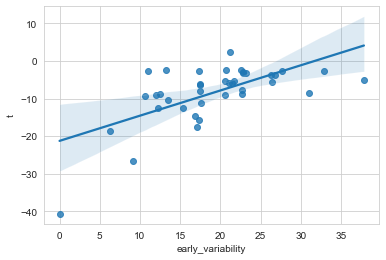

In [32]:
# plot shift vs early variability only for valid shifts
seaborn.regplot(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

In [33]:
r2(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

PearsonRResult(statistic=0.638221609155846, pvalue=1.2360709836110965e-05)

number of invalid subjects: 30


PearsonRResult(statistic=-0.15628497530766725, pvalue=0.578064145757466)

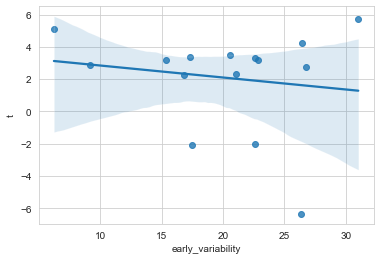

In [34]:
# repeat for baseline

df_shift = dfb[dfb.Block==1].groupby('Subject').apply(shift).apply(pd.Series)
df_shift.columns = ['t', 'p']

print('number of invalid subjects:', len(df_shift[df_shift.p > 0.05]))

# in baseline, plot shift vs early variability only for valid shifts
seaborn.regplot(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')
# and get r2
r2(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

# early versus late variability

In [35]:
len_window = 30

In [36]:
df = pd.DataFrame()
df['early_variability'] = dfb[(dfb.Trial.isin(list(range(1,len_window+1))))&
    (dfb.Block==2)].groupby('Subject').Score.std()
df['late_variability'] = dfb[(dfb.Trial.isin(list(range(200-len_window, 201))))&
    (dfb.Block==2)].groupby('Subject').Score.std()

In [37]:
df.head()

,early_variability,late_variability
Subject,,
AB1,13.456588,11.738169
AG1,21.682891,10.344414
AH1,13.186643,5.448500
AM1,17.646236,21.499987
AN1,27.892496,27.138446


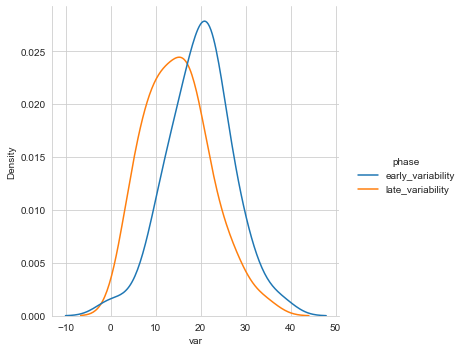

In [38]:
seaborn.displot(df.unstack().rename_axis(['phase','Subject']).rename('var').to_frame(),
                hue='phase', x='var', kind='kde')

In [39]:
# paired t-test on early and late variability.
# alternative='less' means that we want to test if early variability is less than late variability
stats.ttest_rel(df.early_variability, df.late_variability, nan_policy='omit', alternative='greater')

Ttest_relResult(statistic=3.23299195560292, pvalue=0.0011622459108757805)

early variability is more than late variability

# late variability correlates?

### for learning block

In [40]:
df.head()

,early_variability,late_variability
Subject,,
AB1,13.456588,11.738169
AG1,21.682891,10.344414
AH1,13.186643,5.448500
AM1,17.646236,21.499987
AN1,27.892496,27.138446


PearsonRResult(statistic=-0.4637019890770433, pvalue=0.004393504889250304)

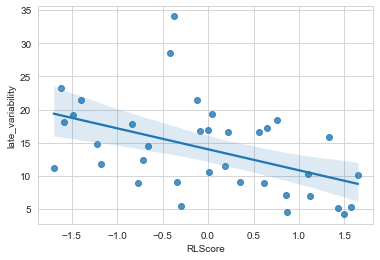

In [41]:
# in learning block, for late variability and fPCA score
seaborn.regplot(data=df.join(fpca_scores),
                 y='late_variability', x='RLScore')
r2(data=df.join(fpca_scores, how='inner'), y='late_variability', x='RLScore')

PearsonRResult(statistic=-0.5156037738054079, pvalue=0.00028921150466461093)

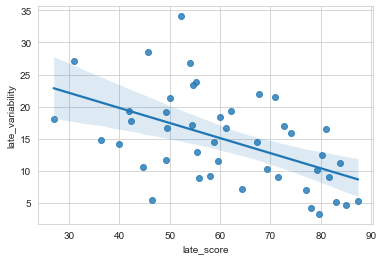

In [42]:
# in learning block, for late variability and mean late learning score
seaborn.regplot(data=df.join(df_late_score),
                 y='late_variability', x='late_score')
r2(data=df.join(df_late_score, how='inner'), y='late_variability', x='late_score')

means they're correlated and we can use late variability as a proxy for late learning score

PearsonRResult(statistic=-0.26526013833510825, pvalue=0.0782307653611724)

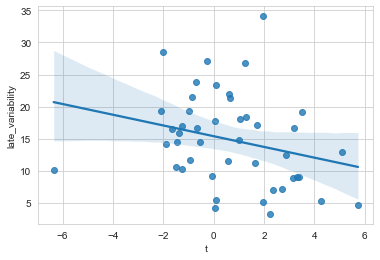

In [43]:
# in learning block, for late variability and shift
seaborn.regplot(data=df.join(df_shift), y='late_variability', x='t')
r2(data=df.join(df_shift, how='inner'), y='late_variability', x='t')

# early var correlates with brain data?

## expansion/contraction

In [44]:
# load early variability for blocks baseline and learning

len_window = 30

df = dfb[dfb.Trial.isin(list(range(1,len_window+1)))].groupby(['Subject', 'Block']).Score.std()
df = df.rename('early_variability')#.reorder_levels([1,0])

df.head()

Subject  Block
AB1      1        17.603846
         2        13.456588
AG1      1        13.700307
         2        21.682891
AH1      1        16.554473
Name: early_variability, dtype: float64

In [45]:
df_var = df.unstack(1).rename(columns={1:'baseline_var', 2:'early_learning_var'})

In [46]:
df_var.head()

Block,baseline_var,early_learning_var
Subject,,
AB1,17.603846,13.456588
AG1,13.700307,21.682891
AH1,16.554473,13.186643
AM1,16.982208,17.646236
AN1,28.063944,27.892496


In [47]:
# load brain data

dfg = pd.read_csv('data/gradients.csv')  # df gradient values
match = pd.read_csv('/Users/qasem/PycharmProjects/gradients-rl-task/data/participants.tsv', delimiter='\t')
dff = pd.merge(dfg, match,
               left_on='subject', right_on='participant_id', how='inner')  # df features
dff = dff.rename(columns={'dicom_dir': 'Subject'})
dff = dff.set_index(['subject', 'Subject', 'epoch', 'region', '7net', '17net'])[['ecc']].unstack(
    'epoch')  # make epochs differentiable
dff = dff.droplevel(level=0, axis=1)
dff['b2e'] = dff['early'] - dff['baseline']
dff['e2l'] = dff['late'] - dff['early']
dff['b2l'] = dff['late'] - dff['baseline']
# dff = dff.reorder_levels([2, 3, 4, 0, 1])
dff.head()

epoch                                                       baseline  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.362379   
                7Networks_LH_Cont_Cing_2 Cont ContC         2.387077   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.334831   
                7Networks_LH_Cont_Cing_4 Cont ContA         0.838871   
                7Networks_LH_Cont_Cing_5 Cont ContC         1.635923   

epoch                                                          early  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  2.389713   
                7Networks_LH_Cont_Cing_2 Cont ContC         2.642581   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.671994   
                7Networks_LH_Cont_Cing_4 Cont ContA         2.075050   
                7Networks_LH_Cont_Cing_5 Cont ContC         1.971246   

epoch                                                           late  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.909058   
                7Networks_LH_Cont_Cing_2 Cont ContC         1.604613   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.089021   
                7Networks_LH_Cont_Cing_4 Cont ContA         1.085350   
                7Networks_LH_Cont_Cing_5 Cont ContC         2.048514   

epoch                                                            b2e  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.027334   
                7Networks_LH_Cont_Cing_2 Cont ContC         0.255503   
                7Networks_LH_Cont_Cing_3 Cont ContC         0.337163   
                7Networks_LH_Cont_Cing_4 Cont ContA         1.236179   
                7Networks_LH_Cont_Cing_5 Cont ContC         0.335323   

epoch                                                            e2l       b2l  
subject Subject region                   7net 17net                             
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -0.480655  0.546679  
                7Networks_LH_Cont_Cing_2 Cont ContC        -1.037968 -0.782465  
                7Networks_LH_Cont_Cing_3 Cont ContC        -0.582973 -0.245810  
                7Networks_LH_Cont_Cing_4 Cont ContA        -0.989700  0.246479  
                7Networks_LH_Cont_Cing_5 Cont ContC         0.077269  0.412591

In [48]:
df = dff.reset_index().merge(df_var, on='Subject', how='left')

In [49]:
df = df.set_index(['region', '7net', '17net', 'subject', 'Subject'])

In [50]:
df.head()

,,,,,baseline,early,late,b2e,e2l,b2l,baseline_var,early_learning_var
region,7net,17net,subject,Subject,,,,,,,,
7Networks_LH_Cont_Cing_1,Cont,SalVentAttnB,1,AB1,1.362379,2.389713,1.909058,1.027334,-0.480655,0.546679,17.603846,13.456588
7Networks_LH_Cont_Cing_2,Cont,ContC,1,AB1,2.387077,2.642581,1.604613,0.255503,-1.037968,-0.782465,17.603846,13.456588
7Networks_LH_Cont_Cing_3,Cont,ContC,1,AB1,2.334831,2.671994,2.089021,0.337163,-0.582973,-0.245810,17.603846,13.456588
7Networks_LH_Cont_Cing_4,Cont,ContA,1,AB1,0.838871,2.075050,1.085350,1.236179,-0.989700,0.246479,17.603846,13.456588
7Networks_LH_Cont_Cing_5,Cont,ContC,1,AB1,1.635923,1.971246,2.048514,0.335323,0.077269,0.412591,17.603846,13.456588


cross correlation

### regions

In [51]:
from scipy.stats import pearsonr
def r_value(data, x, y):   return pearsonr(data[x], data[y])[0]
def p_value(data, x, y):   return pearsonr(data[x], data[y])[1]

In [52]:
import pingouin as pg

In [53]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['baseline_var', 'early_learning_var']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level=0).apply(r_value, x=x, y=y)    # grouped by region
        p = df.groupby(level=0).apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr = pd.concat(l0, axis=1, keys=Y)    # cross correlation

In [54]:
dfcr.head()

baseline_var                                          \
                             baseline                         early             
                                    r         p      pcor         r         p   
region                                                                          
7Networks_LH_Cont_Cing_1    -0.019582  0.909748  0.998994 -0.190815  0.264950   
7Networks_LH_Cont_Cing_2    -0.199564  0.243248  0.998994  0.179477  0.294919   
7Networks_LH_Cont_Cing_3     0.048296  0.779698  0.998994  0.127787  0.457654   
7Networks_LH_Cont_Cing_4     0.168579  0.325689  0.998994 -0.003095  0.985709   
7Networks_LH_Cont_Cing_5    -0.091964  0.593727  0.998994  0.188440  0.271055   

                                                                            \
                                        late                           b2e   
                              pcor         r         p      pcor         r   
region                                                                       
7Networks_LH_Cont_Cing_1  0.999287 -0.107321  0.533280  0.974989 -0.125017   
7Networks_LH_Cont_Cing_2  0.999287 -0.282522  0.095015  0.974989  0.261693   
7Networks_LH_Cont_Cing_3  0.999287 -0.305140  0.070348  0.974989  0.049658   
7Networks_LH_Cont_Cing_4  0.999287 -0.296828  0.078752  0.974989 -0.117835   
7Networks_LH_Cont_Cing_5  0.999287 -0.149410  0.384453  0.974989  0.179675   

                          ... early_learning_var                      \
                          ...              early      late             
                          ...               pcor         r         p   
region                    ...                                          
7Networks_LH_Cont_Cing_1  ...           0.998477 -0.278086  0.100548   
7Networks_LH_Cont_Cing_2  ...           0.912374  0.114438  0.506318   
7Networks_LH_Cont_Cing_3  ...           0.990887  0.149842  0.383065   
7Networks_LH_Cont_Cing_4  ...           0.998477  0.136185  0.428377   
7Networks_LH_Cont_Cing_5  ...           0.878255  0.032549  0.850524   

                                                                            \
                                         b2e                           e2l   
                              pcor         r         p      pcor         r   
region                                                                       
7Networks_LH_Cont_Cing_1  0.999147  0.082311  0.633185  0.896249 -0.224344   
7Networks_LH_Cont_Cing_2  0.999147 -0.189804  0.267539  0.766995  0.211186   
7Networks_LH_Cont_Cing_3  0.999147 -0.263515  0.120452  0.655362  0.172307   
7Networks_LH_Cont_Cing_4  0.999147  0.051219  0.766723  0.943946  0.042623   
7Networks_LH_Cont_Cing_5  0.999147 -0.334248  0.046324  0.520883  0.181345   

                                              
                                              
                                 p      pcor  
region                                        
7Networks_LH_Cont_Cing_1  0.188376  0.983074  
7Networks_LH_Cont_Cing_2  0.216310  0.983074  
7Networks_LH_Cont_Cing_3  0.314947  0.983074  
7Networks_LH_Cont_Cing_4  0.805044  0.983074  
7Networks_LH_Cont_Cing_5  0.289838  0.983074  

[5 rows x 30 columns]

In [55]:
# dfcr['early_learning_var']['baseline']['r'].head()

significant regions out of 1012 regions

In [56]:
p = dfcr.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
baseline_var,0,0,0,0,0
early_learning_var,0,0,0,0,0


from 70 to 30 trials, no significant regions FDR correlated

In [57]:
p = dfcr.xs('p', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
baseline_var,13,18,20,22,12
early_learning_var,82,60,25,91,29


In [58]:
b2e = dfcr['early_learning_var']['b2e']
# b2e[b2e.p<.05]#.tail()

In [59]:
baseline = dfcr['early_learning_var']['baseline']
# baseline[baseline.p<.05].tail()

plotting on brain

In [60]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]
region_names = pd.read_csv('data/regions_sorted.csv')['region']

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


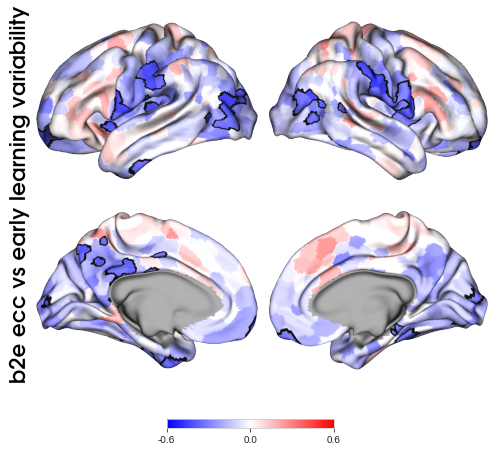

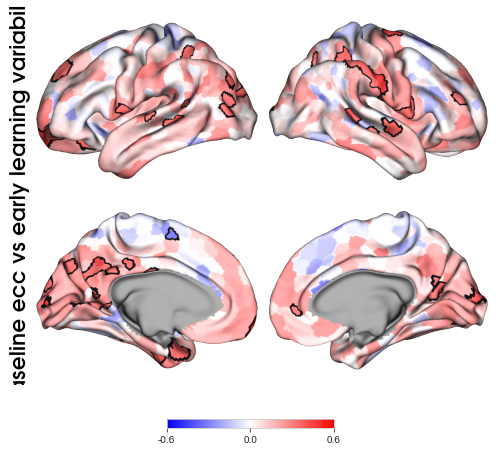

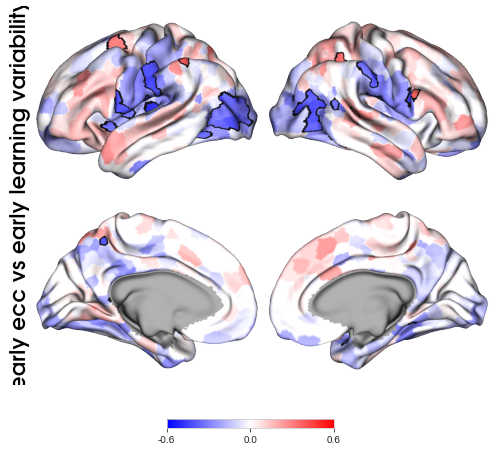

In [61]:
# cortex
metric = 'early_learning_var'

for e in ['b2e', 'baseline', 'early']:
    data = dfcr[metric][e]

    data1 = data['r']
    data1 = data1.loc[region_names]
    data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
    fname = e + ' ecc vs early learning variability'
    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), label_text=[fname])

    p.add_layer(data1, cbar=True, cmap='bwr', color_range=(-.6,.6))

    # seed region outlined
    data2 = (data['p']<.05).loc[region_names]
    data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
    p.add_layer(data2, cbar=False, as_outline=True, cmap='binary')

    figure = p.build()
    # figure.savefig(fname+'.png', dpi=300)

### networks

In [62]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['baseline_var', 'early_learning_var']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level='7net').apply(r_value, x=x, y=y)    # grouped by '7net'
        p = df.groupby(level='7net').apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr7 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

out of 8 networks

In [63]:
p = dfcr7.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
baseline_var,3,5,3,4,5
early_learning_var,7,5,3,6,2


17 networks

In [64]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['baseline_var', 'early_learning_var']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level='17net').apply(r_value, x=x, y=y)    # grouped by '17net'
        p = df.groupby(level='17net').apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr17 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

out of 19 networks

In [65]:
p = dfcr17.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()

,baseline,early,late,b2e,e2l
baseline_var,5,7,6,4,4
early_learning_var,15,7,6,11,13
